In [42]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

import matplotlib
import datetime
from scipy import stats
from statsmodels.stats.anova import anova_lm
from statsmodels.formula.api import ols
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.nonparametric.smoothers_lowess import lowess

run_type = "dry"
#run_type = "wet"


new_day = datetime.datetime.now().strftime("%Y%m%d")

palette = {"DR_lifelong":"red", "AL_lifelong":"dodgerblue", 
           "AL_DR16M":"teal", "AL_DR20M":"gold", "Food":"brown", "AL_DR12M":"magenta"}
path = "../analysis/plots/alpha_beta_diversity/"

In [38]:
# We have alpha values from estimate richness in R
# Read alpha diversity dataframe
a = pd.read_csv("../analysis/alpha_values.csv", sep = ";")
a["Sample_ID"] = a["Sample_id"].str.replace(".", "-")
a = a.drop(columns = ["Sample_id"])
# Read metadata file and format
me = pd.read_csv("../metadata/metadata_F245_16S.csv", sep = ";")

/Users/CMonzo/.conda/envs/MPI/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  after removing the cwd from sys.path.


In [40]:
mea = pd.merge(me.loc[:, ["Sample_ID", "Months", 
        "Treatment", "Cage_No"]], a, on = "Sample_ID")

In [47]:
def boxplot_alpha_all(text, mea):
    fig, ax = plt.subplots(figsize = (13, 5))
    hue_order = ["DR_lifelong", "AL_DR16M", "AL_DR20M", "AL_lifelong", "AL_DR12M"]
    ax = sns.boxplot(data = mea, y = text, x = "Months", hue = "Treatment", 
               palette = palette, hue_order = hue_order, showfliers = False, ax = ax)
    ax = sns.swarmplot(data = mea, y = text, x = "Months", hue = "Treatment",
                      dodge = True, color = ".25", ax = ax, hue_order = hue_order)
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[:4], labels[:4], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize = 18)


    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    for line in leg.get_lines():
        line.set_linewidth(3.5)
    ax.tick_params(axis = "x", labelsize=18)
    ax.tick_params(axis = "y", labelsize=18)
    plt.ylabel("Alpha diversity [{}]".format(text), fontsize = 20)
    plt.xlabel("Age [Months]", fontsize = 20)
    plt.tight_layout()
    matplotlib.rcParams['pdf.fonttype'] = 42

    if run_type != "dry":
        plt.savefig("{}Alpha_boxplot_{}_allDiets_{}.pdf".format(path, text, new_day))
    else:
        plt.show()

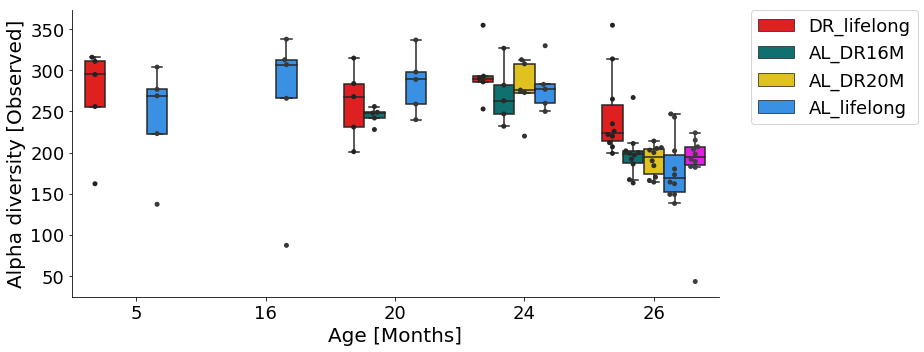

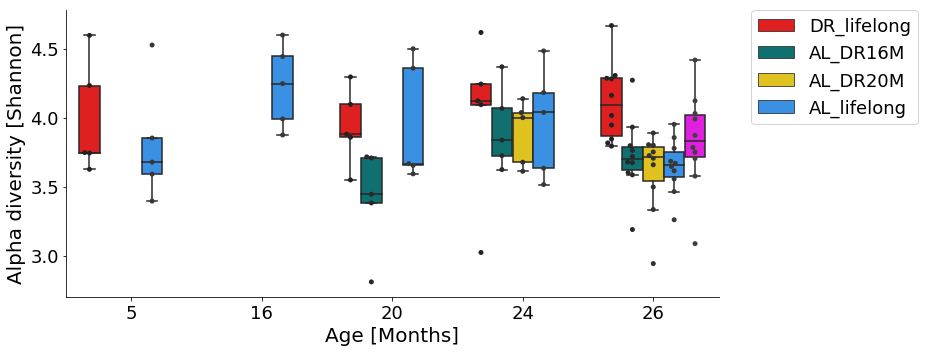

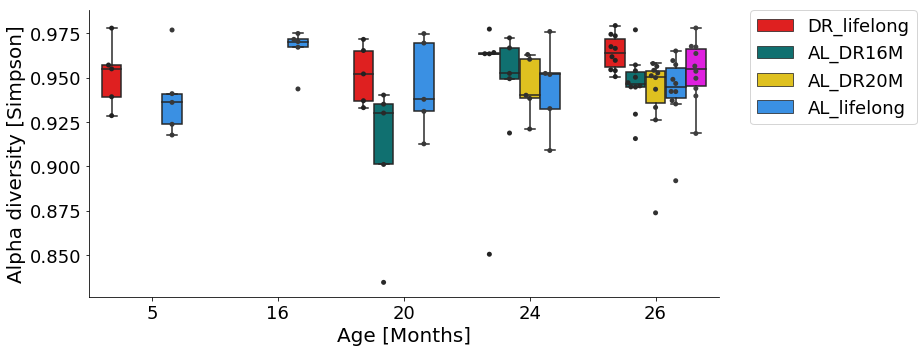

In [48]:
boxplot_alpha_all("Observed", mea)
boxplot_alpha_all("Shannon", mea)
boxplot_alpha_all("Simpson", mea)

In [49]:
# Statistics
print("//ANOVA BETWEEN TREATMENTS WITHIN TIMEPOINTS//")
# Check ANOVA between treatments within timepoints
pd.set_option("display.max_rows", None, "display.max_columns", None)
for e in [5, 20, 24, 26]:
    for method in ["Observed", "Shannon", "Simpson"]:
    
        print("Anova comparing treatments at {} Months {}\n".format(e, method))

        test = mea[mea["Months"] == e]
        mod = ols(f"{method} ~ 0 + Treatment", data = test).fit()
        aov_table = sm.stats.anova_lm(mod, typ=2)
        print(aov_table)

        pair_t = mod.t_test_pairwise("Treatment", method = "Bonferroni")
        print(pd.DataFrame(pair_t.result_frame))

//ANOVA BETWEEN TREATMENTS WITHIN TIMEPOINTS//
Anova comparing treatments at 5 Months Observed

             sum_sq   df          F    PR(>F)
Treatment  651940.0  2.0  77.969264  0.000006
Residual    33446.0  8.0        NaN       NaN
                         coef    std err         t     P>|t|  Conf. Int. Low  \
DR_lifelong-AL_lifelong  26.0  40.893765  0.635794  0.542667      -68.301191   

                         Conf. Int. Upp.  pvalue-Bonferroni  reject-Bonferroni  
DR_lifelong-AL_lifelong       120.301191           0.542667              False  
Anova comparing treatments at 5 Months Shannon

               sum_sq   df           F        PR(>F)
Treatment  152.081359  2.0  424.954636  7.561266e-09
Residual     1.431507  8.0         NaN           NaN
                             coef   std err         t     P>|t|  \
DR_lifelong-AL_lifelong  0.180444  0.267536  0.674468  0.519025   

                         Conf. Int. Low  Conf. Int. Upp.  pvalue-Bonferroni  \
DR_lifelong-AL_lifelon

In [50]:
def linreg_cond_alpha(text, df, method):
    if text == "DR_lifelong":
        color = "red"
        df_prov2 = df[df["Treatment"] == text]
        fig, ax = plt.subplots(figsize = (10, 5))
    elif text == "AL_lifelong":
        color = "dodgerblue"
        df_prov2 = df[df["Treatment"] == text]
        fig, ax = plt.subplots(figsize = (7.8, 5))
    elif text == "AL_DR16M":
        color = "teal"
        df_prov2 = df[df["Treatment"] == text]
        df_prov2 = df_prov2[df_prov2["Months"] > 14]
        fig, ax = plt.subplots(figsize = (7.8, 5))
    elif text == "AL_DR20M":
        color = "gold"
        df_prov2 = df[df["Treatment"] == text]
        df_prov2 = df_prov2[df_prov2["Months"] > 18]
        fig, ax = plt.subplots(figsize = (5.8, 5))

    sns.regplot(data = df_prov2, x = "Months", 
              y = method, scatter_kws = {"s":3, "color":"lightgrey"}, line_kws = {"color":color},
               x_jitter = 0.3)

    plt.title(text, fontsize = 20)

    ax.tick_params(axis = "x", labelsize=18)
    ax.tick_params(axis = "y", labelsize=18)
    ax.set_xlabel("Age [Months]", fontsize = 20)
    ax.set_ylabel("Alpha diversity [{}]".format(method), fontsize = 20)

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    matplotlib.rcParams['pdf.fonttype'] = 42
    plt.tight_layout()
    
    # Linear regression
    x = df_prov2.Months.to_list()
    y = df_prov2[method].to_list()
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    print(f"\nLinear regression for {method} diversity: {text}")
    print(f"Slope: {slope}\nIntercept: {intercept}\np-value: {p_value}\nstd_err: {std_err}")
    

    if run_type != "dry":
        plt.savefig("{}Alpha_linreg_{}_{}_{}.pdf".format(path, text, method, new_day))
    else:
        plt.show()


Linear regression for Shannon diversity: DR_lifelong
Slope: 0.004969369209335331
Intercept: 3.9332594421998475
p-value: 0.6030489454914125
std_err: 0.009424541571650385


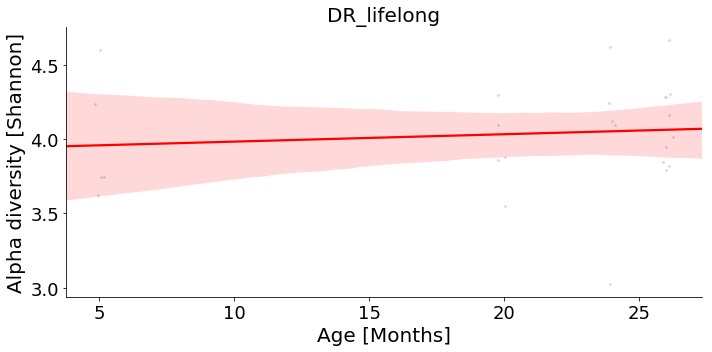


Linear regression for Shannon diversity: AL_lifelong
Slope: -0.008441561536083452
Intercept: 4.041163970092284
p-value: 0.37341860817929384
std_err: 0.009332278583315935


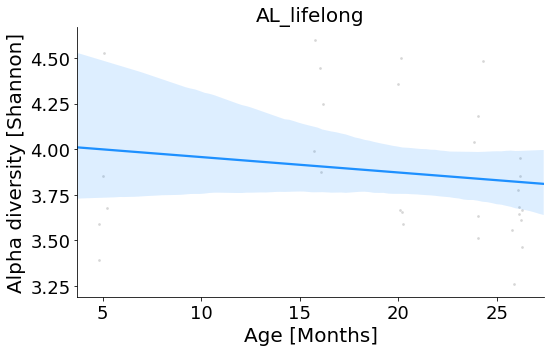


Linear regression for Shannon diversity: AL_DR16M
Slope: 0.0514955375354405
Intercept: 2.4586122745526486
p-value: 0.10172396580138895
std_err: 0.029858924366215085


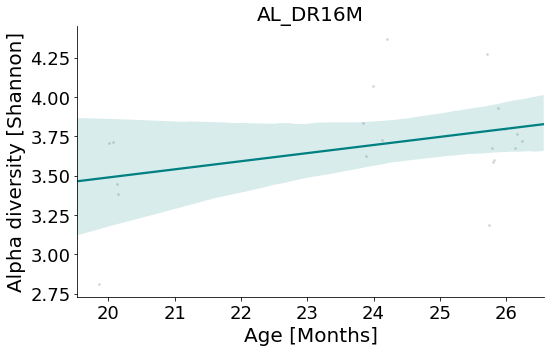


Linear regression for Shannon diversity: AL_DR20M
Slope: -0.14087292957863845
Intercept: 7.273314972258693
p-value: 0.07915883020307912
std_err: 0.07395422836638031


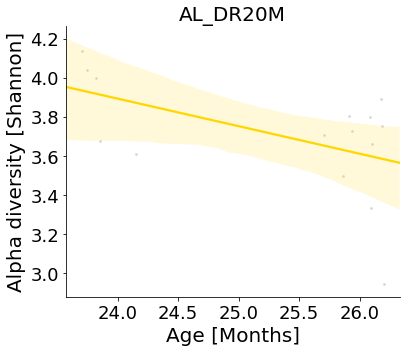

In [52]:
linreg_cond_alpha("DR_lifelong", mea, "Shannon")
linreg_cond_alpha("AL_lifelong", mea, "Shannon")
linreg_cond_alpha("AL_DR16M", mea, "Shannon")
linreg_cond_alpha("AL_DR20M", mea, "Shannon")

In [53]:
# Calculate lowess using statsmodels
treats = ["AL_lifelong", "DR_lifelong", "AL_DR16M", "AL_DR20M"]
df_s = pd.DataFrame()
for t in treats:
    subs = mea[mea["Treatment"] == t]
    x = np.array(subs["Months"])
    y = np.array(subs["Shannon"])
    filtered = lowess(subs.Shannon, subs.Months, frac=0.8, is_sorted = False, return_sorted = True, it = 10) 
    d = pd.DataFrame(filtered)
    d.columns = ["Months", "Shannon"]
    d["Treatment"] = [t]*len(d["Months"])
    df_s = pd.concat([df_s, d])

/Users/CMonzo/.conda/envs/MPI/lib/python3.7/site-packages/statsmodels/nonparametric/smoothers_lowess.py:165: RuntimeWarning: invalid value encountered in greater_equal
  res = _lowess(y, x, frac=frac, it=it, delta=delta)


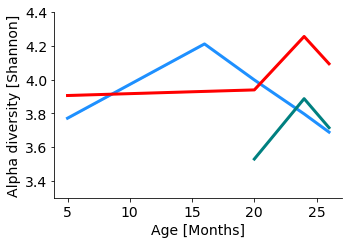

In [58]:
fig, ax = plt.subplots(figsize = (5, 3.5))
sns.lineplot(data = df_s, x = "Months", y = "Shannon", hue = "Treatment", palette = palette, legend = False, 
            linewidth = 3)

ax.set_xlabel("Age [Months]", fontsize = 14)
ax.set_ylabel("Alpha diversity [Shannon]", fontsize = 14)
ax.tick_params(labelsize=14)


sns.despine()
plt.ylim(3.3, 4.4)
matplotlib.rcParams['pdf.fonttype'] = 42
plt.tight_layout()
if run_type != "dry":
    plt.savefig("{}Alpha_Lowess_Shannon_{}.pdf".format(path, new_day))
else:
    plt.show()